In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import accuracy_score

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_comb = df_train.append(df_test)

X = pd.DataFrame()
df_comb.head()

<ipython-input-2-0d48f7274744>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comb = df_train.append(df_test)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
def encode_sex(x):
    return 1 if x == 'female' else 0

def family_size(x):
    size = x.SibSp + x.Parch 
    return 4 if size > 3 else size

X['Sex'] = df_comb.Sex.map(encode_sex)
X['Pclass'] = df_comb.Pclass
X['FamilySize'] = df_comb.apply(family_size, axis=1)

In [ ]:
fare_median = df_train.groupby(['Sex', 'Pclass']).Fare.median()
fare_median.name = 'FareMedian'

age_mean = df_train.groupby(['Sex', 'Pclass']).Age.mean()
age_mean.name = 'AgeMean'

In [ ]:
def join(df, stat):
    return pd.merge(df, stat.to_frame(), left_on=['Sex', 'Pclass'], right_index=True, how='left')


In [ ]:
X['Fare'] = df_comb.Fare.fillna(join(df_comb, fare_median).FareMedian)
X['Age'] = df_comb.Age.fillna(join(df_comb, age_mean).AgeMean)

In [ ]:
X.head()

,Sex,Pclass,FamilySize,Fare,Age
0,0,3,1,7.2500,22.0
1,1,1,1,71.2833,38.0
2,1,3,0,7.9250,26.0
3,1,1,1,53.1000,35.0
4,0,3,0,8.0500,35.0


In [ ]:
def quantiles(series, num):
    return pd.qcut(series, num, retbins=True)[1]

def discretize(series, bins):
    return pd.cut(series, bins, labels=range(len(bins)-1), include_lowest=True)
    
X['Fare'] = discretize(X.Fare, quantiles(df_comb.Fare, 10))
X['Age'] = discretize(X.Age, quantiles(df_comb.Age, 10))
X.head()

,Sex,Pclass,FamilySize,Fare,Age
0,0,3,1,0,2
1,1,1,1,8,7
2,1,3,0,2,4
3,1,1,1,8,6
4,0,3,0,2,6


In [ ]:
X_train = X.iloc[:df_train.shape[0]]
X_test = X.iloc[df_train.shape[0]:]

y_train = df_train.Survived


In [ ]:
clf_1 = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=0)
clf_1.fit(X_train, y_train)
# Number of folds for cross validation
num_folds = 7

In [ ]:
def plot_curve(ticks, train_scores, test_scores):
    train_scores_mean = -1 * np.mean(train_scores, axis=1)
    train_scores_std = -1 * np.std(train_scores, axis=1)
    test_scores_mean = -1 * np.mean(test_scores, axis=1)
    test_scores_std = -1 * np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(ticks, 
                     train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(ticks, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(ticks, train_scores_mean, 'b-', label='Training score')
    plt.plot(ticks, test_scores_mean, 'r-', label='Test score')
    plt.legend(fancybox=True, facecolor='w')

    return plt.gca()

In [ ]:
def plot_validation_curve(clf, X, y, param_name, param_range, scoring='roc_auc'):
    plt.xkcd()
    ax = plot_curve(param_range, *validation_curve(clf, X, y, cv=num_folds, 
                                                   scoring=scoring, 
                                                   param_name=param_name, 
                                                   param_range=param_range, n_jobs=-1))
    ax.set_title('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(2,12)
    ax.set_ylim(-0.97, -0.83)
    ax.set_ylabel('Error')
    ax.set_xlabel('Model complexity')
    ax.text(9, -0.94, 'Overfitting', fontsize=22)
    ax.text(3, -0.94, 'Underfitting', fontsize=22)
    ax.axvline(7, ls='--')
    plt.tight_layout()

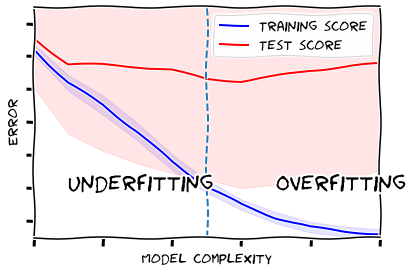

In [ ]:
plot_validation_curve(clf_1, X_train, y_train, param_name='max_depth', param_range=range(2,13))

In [ ]:
clf_2 = RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=0,
                                min_samples_split=10, min_samples_leaf=10)
clf_2.fit(X_train, y_train)
# Number of folds for cross validation
num_folds = 10

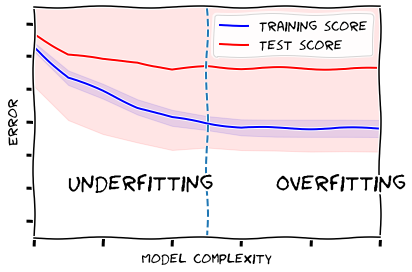

In [ ]:
plot_validation_curve(clf_2, X_train, y_train, param_name='max_depth', param_range=range(2,13))